# Credit Default Prediction: A Machine Learning Approach

# **Project Overview:** This project aims to develop a robust machine learning model for predicting credit defaults. The objective is to maximize **recall**, minimizing false negatives (incorrectly predicting loan repayment when a default occurs) to reduce financial losses. This project demonstrates data analysis, preprocessing, model training, evaluation, and hyperparameter tuning. This version of the code incorporates all the improvement recommendations from the previous version.

## 1. Installation and Library Import

In [6]:
# Install necessary libraries. Uncomment if needed:
# !pip install numpy pandas seaborn matplotlib scikit-learn imbalanced-learn xgboost shap

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import shap
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

## 2. Data Loading and Preprocessing

## **Data Source:** LendingClub.com loan data via Kaggle ([dataset link](https://www.kaggle.com/itssuru/loan-data)).
### Data Dictionary
| Variable          | Explanation                                                                                                             |
|-------------------|------------------------------------------------------------------------------------------------------------------------|
| credit_policy     | 1: Meets credit underwriting criteria; 0: Otherwise.                                                                   |
| purpose           | The purpose of the loan (e.g., debt consolidation, credit card).                                                    |
| int_rate          | Interest rate (higher rates often signify riskier borrowers).                                                        |
| installment       | Monthly payment amount.                                                                                          |
| log_annual_inc    | Natural log of the self-reported annual income.                                                                            |
| dti               | Debt-to-income ratio.                                                                                                 |
| fico              | FICO credit score.                                                                                                     |
| days_with_cr_line | Number of days the borrower has had a credit line.                                                                      |
| revol_bal         | Revolving balance (outstanding credit card balance).                                                                       |
| revol_util        | Revolving line utilization rate (credit used relative to total credit available).                                            |
| inq_last_6mths    | Inquiries in past 6 months.                                                                                 |
| delinq_2yrs       | Delinquencies (30+ days past due) in the past 2 years.                                                              |
| pub_rec           | Number of derogatory public records.                                                                                  |
| **not_fully_paid**  | **Target variable:** 1: Loan not fully paid (default); 0: Loan fully paid.                                           |

In [8]:
def load_and_preprocess_data(file_path):
    """Loads, cleans, and preprocesses the loan data."""
    loan_data = pd.read_csv(file_path)
    print(f"✨ Data loaded. Shape: {loan_data.shape}")

    # Handling missing values
    loan_data.dropna(inplace=True)
    print("✨ Missing values handled.\n")

    le = LabelEncoder()
    loan_data['purpose'] = le.fit_transform(loan_data['purpose'])
    print("✨ 'purpose' feature encoded.\n")
    for code, label in enumerate(le.classes_):
        print(f'Code: {code}, Label: {label}')
    return loan_data

loan_data = load_and_preprocess_data('source/loan_data.csv')
loan_data.head()

✨ Data loaded. Shape: (9578, 14)
✨ Missing values handled.

✨ 'purpose' feature encoded.

Code: 0, Label: all_other
Code: 1, Label: credit_card
Code: 2, Label: debt_consolidation
Code: 3, Label: educational
Code: 4, Label: home_improvement
Code: 5, Label: major_purchase
Code: 6, Label: small_business


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,2,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,2,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,2,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


## 3. Exploratory Data Analysis (EDA)

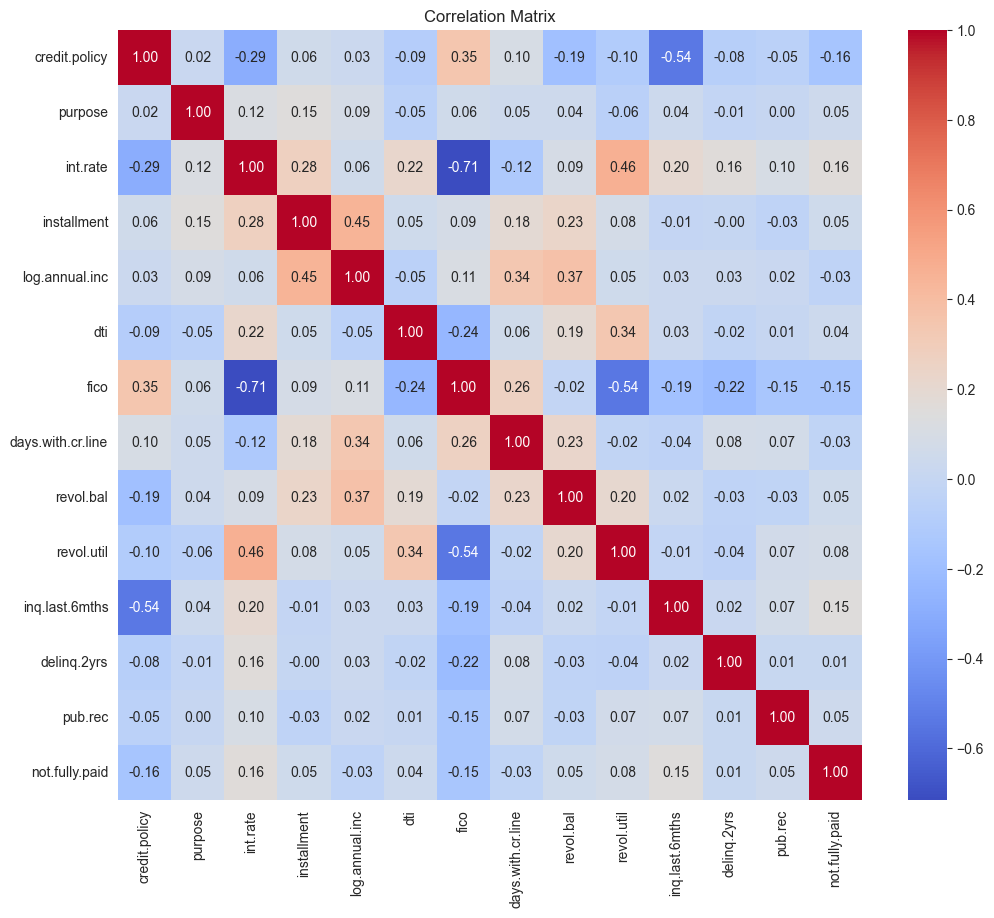

In [9]:
# Correlation Heatmap
corr_matrix = loan_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Upon analyzing the dataset, it became evident that the features 'interest rate', 'FICO score', 'log of annual income', 'debt-to-income ratio', and 'installment amount' exhibited the strongest correlation with loan default. Consequently, these features will be the primary focus of subsequent modeling efforts.

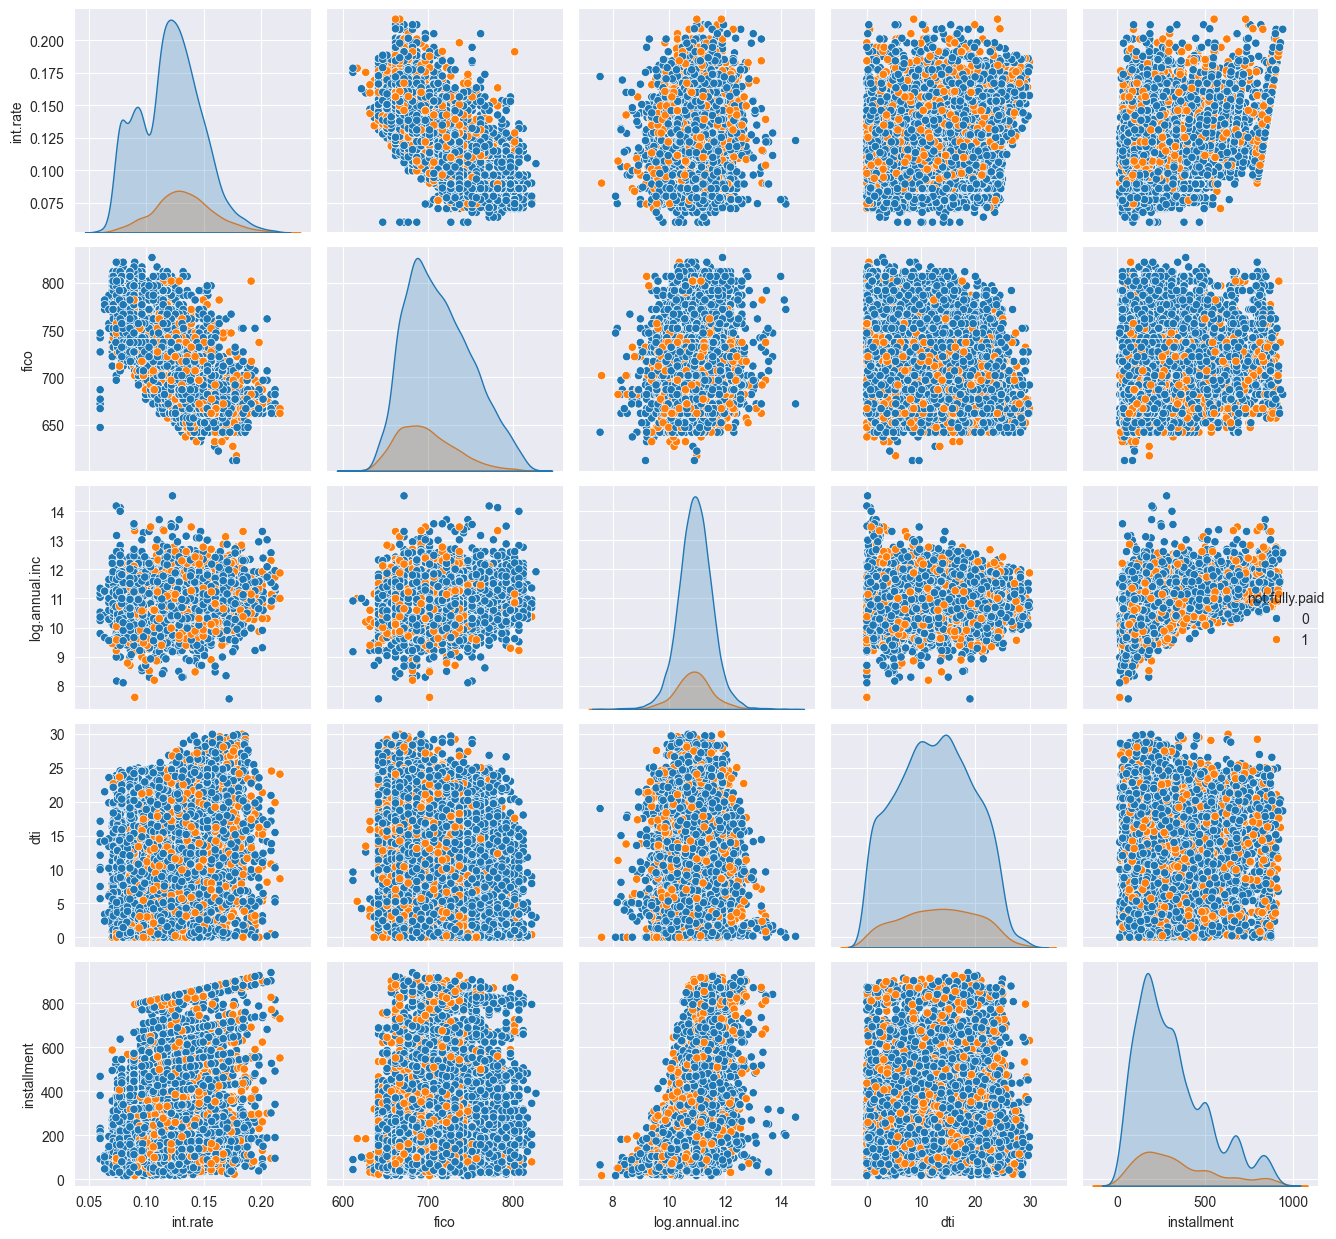

In [10]:
# Optimized EDA: Pairplot for numerical features with hue based on the target variable
sns.pairplot(loan_data, hue='not.fully.paid', vars=['int.rate', 'fico', 'log.annual.inc', 'dti', 'installment'], diag_kind='kde')
plt.tight_layout()  # Вызовите это перед сохранением графика
plt.savefig('source.png')
plt.show()

## 4. Data Splitting and Class Imbalance Handling

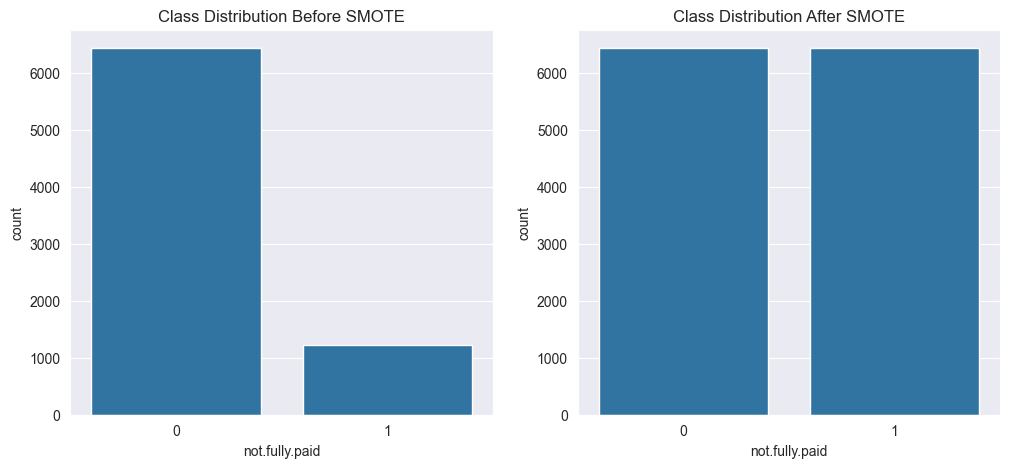

In [11]:
y = loan_data['not.fully.paid']
X = loan_data.drop('not.fully.paid', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Visualizing class distribution before and after SMOTE (combined into one plot)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Class Distribution Before SMOTE')
sns.countplot(x=y_train_resampled, ax=axes[1])
axes[1].set_title('Class Distribution After SMOTE')
plt.show()


## 5. Model Training and Evaluation

In [12]:
# Pipeline for preprocessing (scaling)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['purpose', 'credit.policy']
numerical_features = X.columns.drop(categorical_features).tolist()  # All other features are numerical

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        # handle_unknown for new categories in test data
    ])


# Function for training and evaluation using cross-validation and multiple metrics
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    """Trains and evaluates a classification model."""

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print("Classification Report:\n", classification_report(y_test, y_pred))
    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall}")
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC-AUC: {roc_auc}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    plt.show()
    print('_________________________________________________________________\n')
    return recall, roc_auc


# Dictionary to store results
results = {}

### 5.4 LogisticRegression with Hyperparameter Tuning

Best parameters for LogisticRegression: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.75      0.80      1609
           1       0.24      0.43      0.31       307

    accuracy                           0.69      1916
   macro avg       0.56      0.59      0.56      1916
weighted avg       0.77      0.69      0.72      1916

Recall: 0.42996742671009774
ROC-AUC: 0.631371175573879


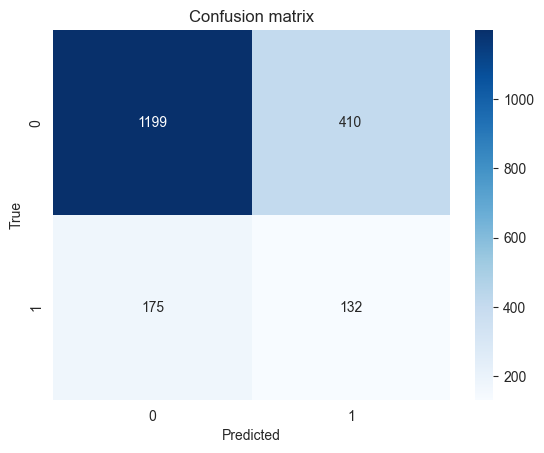

_________________________________________________________________


In [13]:
### 5.4 LogisticRegression with Hyperparameter Tuning
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))  # Increased max_iter for convergence
])

lr_param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 10],
    'classifier__max_iter': [1000, 2000, 5000],
    'classifier__solver': ['liblinear', 'saga']  # Поддерживаемые solvers для penalty 'l1' и 'l2'
}

grid_search_lr = GridSearchCV(lr_pipeline, lr_param_grid,
                              cv=StratifiedKFold(5), scoring='recall', n_jobs=-1)

grid_search_lr.fit(X_train_resampled, y_train_resampled)
best_lr_model = grid_search_lr.best_estimator_

print(f"Best parameters for LogisticRegression: {grid_search_lr.best_params_}")
recall, roc_auc = train_and_evaluate_model(best_lr_model, X_train_resampled, X_test, y_train_resampled, y_test)
results['LogisticRegression_tuned'] = {'recall': recall, 'roc_auc': roc_auc}

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.75      0.80      1609
           1       0.24      0.43      0.31       307

    accuracy                           0.69      1916
   macro avg       0.56      0.59      0.56      1916
weighted avg       0.77      0.69      0.72      1916


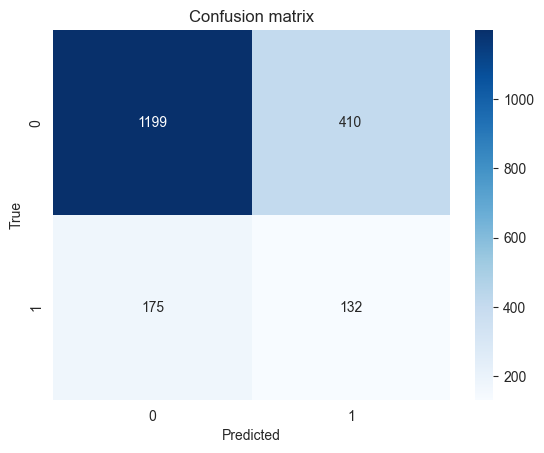

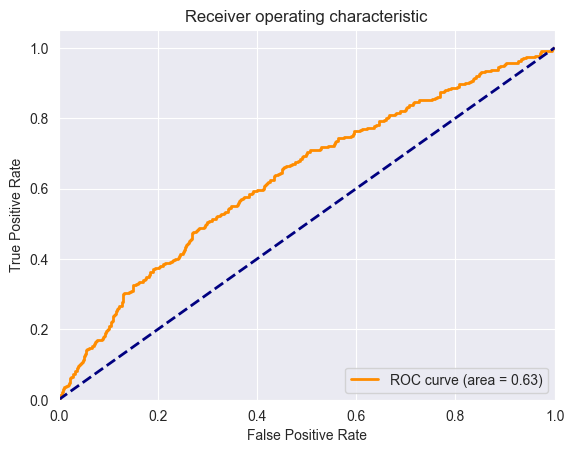

In [14]:
## **Визуализация результатов**
# Classification Report
print("Classification Report:\n", classification_report(y_test, best_lr_model.predict(X_test)))

# Confusion Matrix
cm = confusion_matrix(y_test, best_lr_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

# ROC-AUC Curve
y_prob = best_lr_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

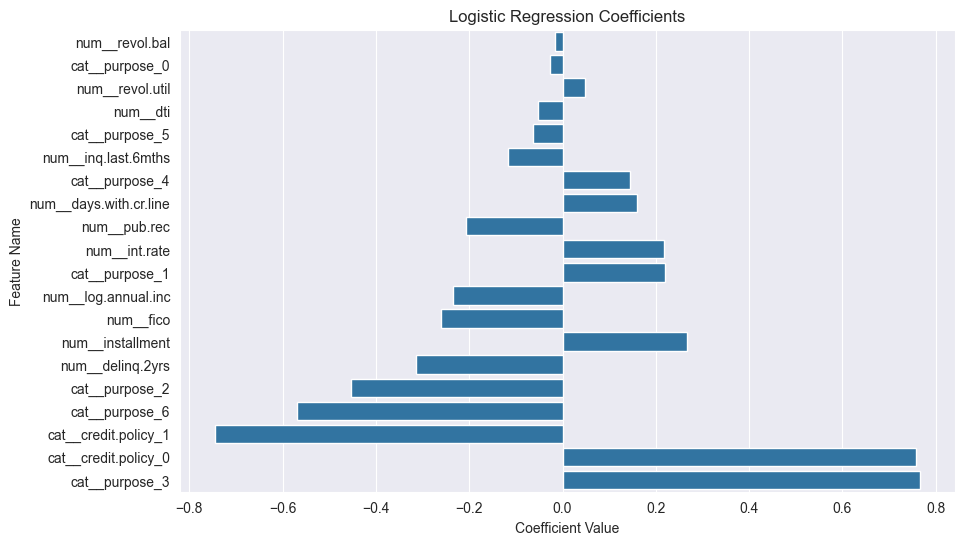

In [15]:
# **Интерпретация коэффициентов логистического регрессора**
# Get the feature names and coefficients
feature_names = best_lr_model.named_steps['preprocessor'].get_feature_names_out()
coefficients = best_lr_model.named_steps['classifier'].coef_[0]

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by absolute value of coefficients
results_df = results_df.sort_values(by='Coefficient', key=abs)

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=results_df)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.show()

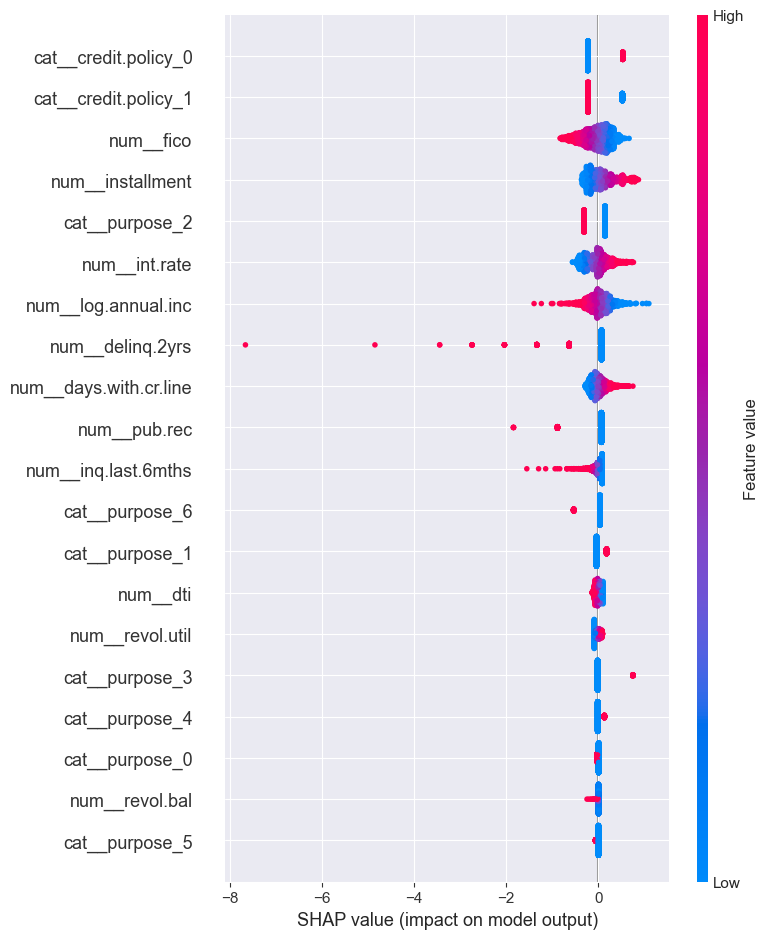

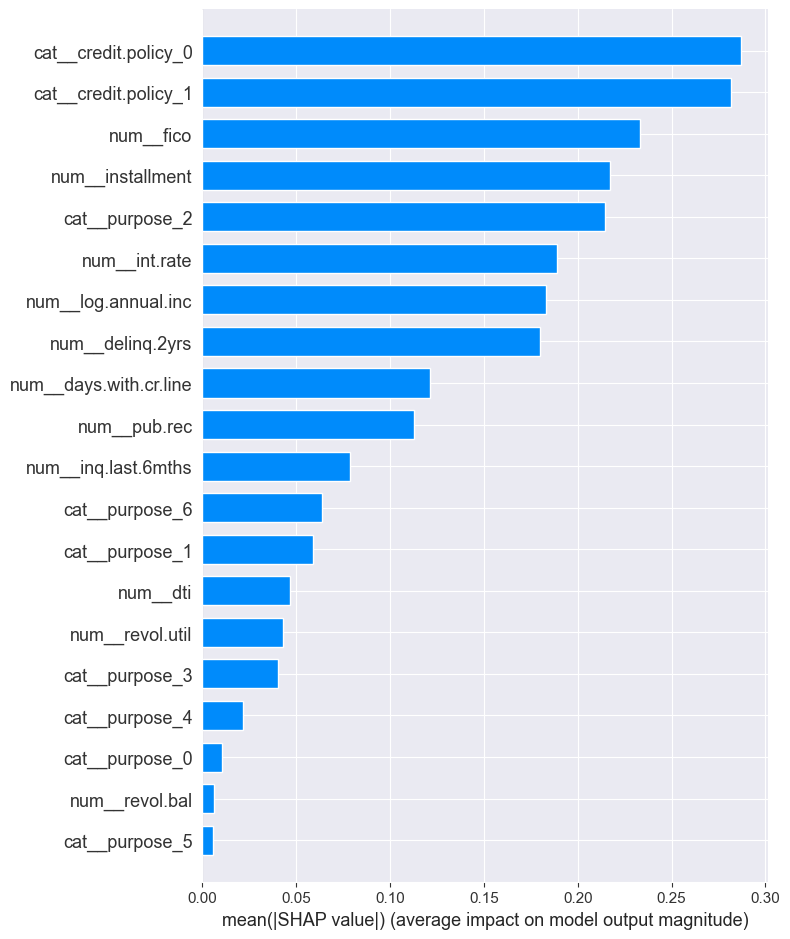

In [16]:
## **SHAP значения для интерпретации модели**
# SHAP values for interpreting the best model
preprocessed_X_train = best_lr_model.named_steps['preprocessor'].transform(X_train_resampled)
preprocessed_X_test = best_lr_model.named_steps['preprocessor'].transform(X_test)

explainer = shap.LinearExplainer(best_lr_model.named_steps['classifier'], preprocessed_X_train)
shap_values = explainer.shap_values(preprocessed_X_test)

# Ensure feature names are correctly aligned
feature_names = best_lr_model.named_steps['preprocessor'].get_feature_names_out()

# Check if shapes match
assert shap_values.shape[1] == preprocessed_X_test.shape[1], "Shapes do not match"

# Plot SHAP values using preprocessed data
shap.summary_plot(shap_values, preprocessed_X_test, feature_names=feature_names)
shap.summary_plot(shap_values, preprocessed_X_test, feature_names=feature_names, plot_type="bar")